In [ ]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)
#from datetime import datetime as dt

# Visualization packages:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# import plotly.graph_objs as go 
%matplotlib inline

# Import all necessary libraries.

import warnings
# import plots as p
import helper_functions as f
# import data_testing as dt
# import data_prep as dp

import itertools
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import datetime as dt
from IPython.display import HTML # to see everything
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")
# matplotlib.rcParams['figure.dpi'] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

Energy savings has two keys elements:
- forecasting energy consumption without any energy saving measures 
- forecasting energy consumption after certain energy saving measures

This notebook predict 

# Dataset:

In [ ]:
# training data
train = pd.read_csv("data/train.csv", parse_dates=['timestamp'])
weather_train = pd.read_csv("data/weather_train.csv", parse_dates=['timestamp'])
metadata = pd.read_csv("data/building_metadata.csv")

print('Size of training data', train.shape)
print('Mem. size of original training data', train.memory_usage().sum()/1024**2)
print('----------------------------------')
print('Size of training weather data', weather_train.shape)
print('Mem. size of original training weather data', weather_train.memory_usage().sum()/1024**2)
print('----------------------------------')
print('Size of building meta data', metadata.shape)
print('Mem. size of original building meta data', metadata.memory_usage().sum()/1024**2)

Size of training data (1636538, 4)
Mem. size of original training data 49.94329833984375
----------------------------------
Size of training weather data (139773, 9)
Mem. size of original training weather data 9.597572326660156
----------------------------------
Size of building meta data (1449, 6)
Mem. size of original building meta data 0.0664520263671875


## Files
train.csv
> - **building_id** - Foreign key for the building metadata.
- **meter** - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
- **timestamp** - When the measurement was taken
- **meter_reading** - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. #### building_meta.csv  

metadata.csv
> - **site_id** - Foreign key for the weather files.
- **building_id** - Foreign key for training.csv
- **primary_use** - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- **square_feet** - Gross floor area of the building
- **year_built** - Year building was opened
- **floorcount** - Number of floors of the building #### weather[train/test].csv Weather data from a meteorological station as close as possible to the site.  

Weather_train.csv
> **site_id**  
**timestamp** - When the measurement was taken  
**air_temperature** - Degrees Celsius  
**cloud_coverage** - Portion of the sky covered in clouds, in oktas  
**dew_temperature** - Degrees Celsius  
**precip_depth_1_hr** - Millimeters  
**sea_level_pressure** - Millibar/hectopascals  
**wind_direction** - Compass direction (0-360)  
**wind_speed** - Meters per second

## Reducing memory

In [7]:
## Reducing memory
train_df = f.reduce_mem_usage(train)
print('Mem. size of reduced training data', train_df.shape)
print('----------------------------------')
weather_train_df = f.reduce_mem_usage(weather_train)
print('Mem. size of reduced training weather data', weather_train_df.shape)
print('----------------------------------')
metadata_train_df = f.reduce_mem_usage(metadata)
print('Mem. size of reduced building meta data', metadata_train_df.shape)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. size of reduced training data (20216100, 4)
----------------------------------
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. size of reduced training weather data (139773, 9)
----------------------------------
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. size of reduced building meta data (1449, 6)


***there are 15 different site_ids***

# Training data : Exploratory Data Analysis (EDA)
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

# Merging into train dataset

In [15]:
train_df = train_df.merge(metadata_train_df, on='building_id', how='left')
train_df = train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

del metadata_train_df, weather_train_df
gc.collect();

NameError: name 'metadata_train_df' is not defined

In [16]:
train = train_df.copy()
print(train.shape)
train.info()

(20216100, 16)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               int8
primary_use           object
square_feet           int32
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 1.0+ GB


### Save the dataframe as csv file

In [17]:
train.to_csv(r'data/energy_consumption_data.csv')

KeyboardInterrupt: 

In [13]:
office_1249 = train[train.building_id == 1249]
office_1249.to_csv(r'data/office_1249.csv')

In [14]:
office_1249.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1856,1249,0,2016-01-01 00:00:00,299.000,14,Office,159384,nan,nan,nan,nan,nan,nan,nan,nan,nan
1857,1249,1,2016-01-01 00:00:00,695.555,14,Office,159384,nan,nan,nan,nan,nan,nan,nan,nan,nan
1858,1249,2,2016-01-01 00:00:00,899.640,14,Office,159384,nan,nan,nan,nan,nan,nan,nan,nan,nan
1859,1249,3,2016-01-01 00:00:00,840.861,14,Office,159384,nan,nan,nan,nan,nan,nan,nan,nan,nan
4152,1249,0,2016-01-01 01:00:00,298.000,14,Office,159384,nan,nan,5.602,0.000,-0.600,0.000,1019.500,300.000,2.600


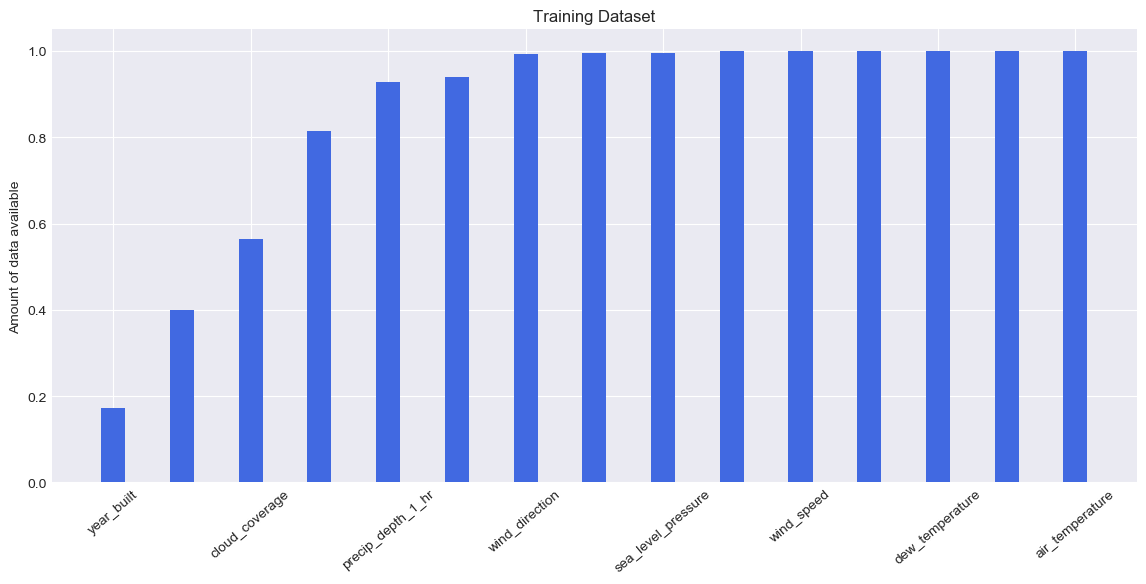

In [34]:
# train_data = (train.count()/len(train)).drop('meter_reading').sort_values().values
# ind = np.arange(len(train_data))
# # width = 0.35

# fig, axes = plt.subplots(1, 1, figsize=(14, 6), dpi=100)
# axes.bar(ind, train_data, width, color='royalblue')
# axes.set_ylabel('Amount of data available');
# axes.set_xticks(ind, width)
# axes.set_xticklabels((train.count()/len(train)).drop('meter_reading').sort_values().index, rotation=40)
# axes.set_title('Training Dataset')
# plt.show()

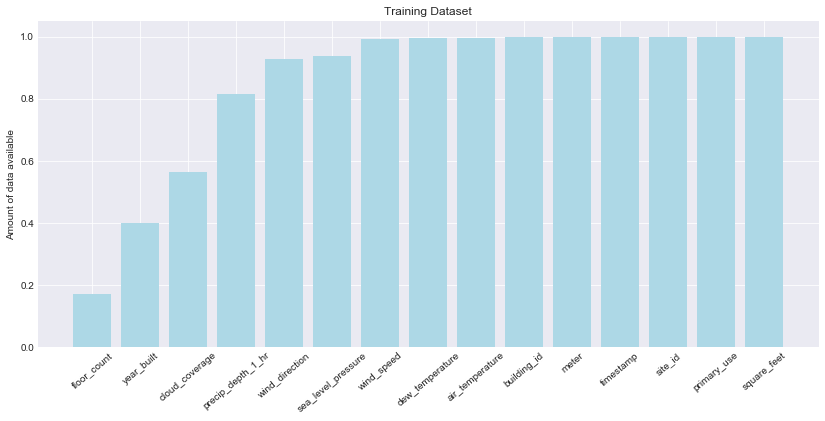

In [43]:
train_data = (train.count()/len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
axes.bar(ind, train_data, color='lightblue')
axes.set_ylabel('Amount of data available');
axes.set_xticks(ind)
axes.set_xticklabels((train.count()/len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.set_title('Training Dataset')
plt.show()

In [50]:
train.groupby(['site_id', 'primary_use'])['building_id'].count()
# train_daily = train_df.groupby(['date', 'building_id', 'meter'])[['meter_reading']].sum()

site_id  primary_use                  
0        Education                         345329
         Entertainment/public assembly      43564
         Lodging/residential               263621
         Office                            246264
         Other                              47654
         Parking                            70272
         Retail                             59958
1        Education                         263493
         Entertainment/public assembly       8784
         Lodging/residential                87840
         Office                            158109
         Public services                    35131
2        Education                        1261874
         Entertainment/public assembly     324352
         Food sales and service             43909
         Healthcare                         17545
         Lodging/residential               289046
         Office                            409250
         Parking                            26345
         Pu

# Limiting dataset

since the dataset is a lot, I limit my self to only office buildings at site_id of 0

In [90]:
train_office = train[(train['site_id']==0) & (train['primary_use']=='Office')]
print(train_office.shape)
train_office.drop('floor_count', axis=1, inplace=True)
train_office.memory_usage().sum()/1024**2

(246264, 16)


12.212493896484375

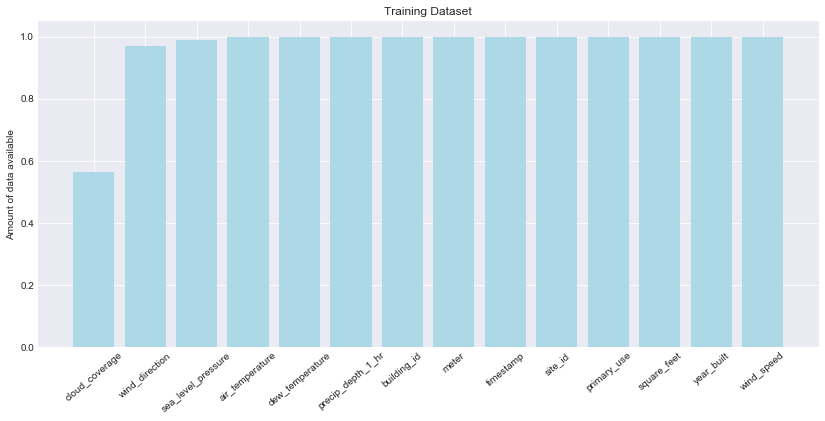

In [91]:
train_odata = (train_office.count()/len(train_office)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_odata))

fig, axes = plt.subplots(1, 1, figsize=(14, 6))
axes.bar(ind, train_odata, color='lightblue')
axes.set_ylabel('Amount of data available');
axes.set_xticks(ind)
axes.set_xticklabels((train_office.count()/len(train_office)).drop('meter_reading').sort_values().index, rotation=40)
axes.set_title('Training Dataset')
plt.show()

In [1]:
train_office.shape

NameError: name 'train_office' is not defined

In [67]:
# train_office.isna().sum()
# checking the 'nan' columns 
nan_cols = [i for i in train_office.columns if train_office[i].isnull().any()]
nan_cols
# (246264, 16)

['floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction']

In [78]:
export_csv = train_office.to_csv (r'data\office_data.csv', index = None, header=True)


In [85]:
office_data = pd.read_csv('data/office_data.csv')
len(office_data.building_id.value_counts())
office_data.shape

(246264, 16)

In [73]:
train_office[train_office.air_temperature == -200]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
844101,9,0,2016-01-16 08:00:00,0.000,0,Office,27000,2010.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844107,15,0,2016-01-16 08:00:00,0.000,0,Office,83957,1974.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844109,17,0,2016-01-16 08:00:00,0.000,0,Office,15250,1980.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844111,19,0,2016-01-16 08:00:00,0.000,0,Office,18717,2004.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844113,21,0,2016-01-16 08:00:00,0.000,0,Office,7043,1990.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844117,25,0,2016-01-16 08:00:00,0.000,0,Office,103286,1969.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844118,26,0,2016-01-16 08:00:00,0.000,0,Office,26953,2005.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844120,28,0,2016-01-16 08:00:00,0.000,0,Office,52957,2016.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844123,32,0,2016-01-16 08:00:00,0.000,0,Office,48392,2005.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500
844129,38,0,2016-01-16 08:00:00,0.000,0,Office,12769,2013.000,-200.000,-200.000,-200.000,-200.000,0.000,-200.000,180.000,1.500


In [71]:
imputed_columns = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
                   'sea_level_pressure', 'wind_direction']
for j in imputed_columns:
    for i in range(0, len(train_office)):
#         sample_df[j].fillna(sample_df[i-1])#, inplace=True)
        if train_office[j][i] == -200:
#             print("yes")
            train_office[j][i] = train_office[j][i-1]

KeyError: 0

floor count information was missing in the dataset, so I dropped that column.

## Checking missing data for train_df

In [ ]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
missing__train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data

## Checking missing values for weather_train_df

In [ ]:
total = weather_train_df.isnull().sum().sort_values(ascending=False)
percent = (weather_train_df.isnull().sum()/weather_train_df.isnull().count()*100).sort_values(ascending=False)
missing__weather_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__weather_data

## Checking missing values for Metadata_train_df

In [ ]:
total = metadata_train_df.isnull().sum().sort_values(ascending=False)
percent = (metadata_train_df.isnull().sum()/metadata_train_df.isnull().count()*100).sort_values(ascending=False)
missing__metadata_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__metadata_data

# Ploting Training set

In [ ]:
import visualization_1 as vis
vis.plot_dist_col(weather_train_df)

In [ ]:
vis.plot_dist_col(weather_train_df, 'cloud_coverage')

In [ ]:
vis.plot_dist_col(weather_train_df, 'dew_temperature')

In [ ]:
vis.plot_dist_col(weather_train_df, 'precip_depth_1_hr')

In [ ]:
vis.plot_dist_col(weather_train_df, 'sea_level_pressure')

In [ ]:
vis.plot_dist_col(weather_train_df, 'wind_direction')

In [ ]:
vis.plot_dist_col(weather_train_df, 'wind_speed')

In [ ]:
np.unique(metadata_train_df[metadata_train_df['primary_use']=='Education']['site_id'], return_counts=True)

# Sample Single Series Analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Meter Reading')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading')
plt.plot(ts);

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [ ]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

In [ ]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

# Outliers 

In [ ]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8));

# Grouping data in a daily basis

In [ ]:
def split_timestamp(df):
    """Splits the timestamp to month and so on."""
    df['month'] = df['timestamp'].dt.month.astype('uint8')
#     df['date'] = df['timestamp'].dt.date.astype('uint8')
    df['day_of_month'] = df['timestamp'].dt.day.astype('uint8')
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype('uint8')
    df['hour'] = df['timestamp'].dt.hour.astype('uint8')
    
    return df

In [ ]:
train_df.head()

In [ ]:
# train_df['month'] = train_df['timestamp'].dt.month.astype('uint8')
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: "Electricity", 
                                                                         1: "ChilledWater",
                                                                         2:"Steam",
                                                                         3:"HotWater"
                                                                        })
train_df['date'] = train_df['timestamp'].dt.date

In [ ]:
train_daily = train_df.groupby(['date', 'building_id', 'meter'])[['meter_reading']].sum()
train_daily

In [ ]:
train_daily_agg = train_df.groupby(['date', 'meter'])[['meter_reading']].agg(['sum', 'mean', 'idxmax', 'max'])
train_daily_agg = train_daily_agg.reset_index()
level_0 = train_daily_agg.columns.droplevel(0)
level_1 = train_daily_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
train_daily_agg.columns = level_1 + level_0
train_daily_agg.rename_axis(None, axis=1)
train_daily_agg.head()

0: Monday and 6: Sunday

In [ ]:
fig_total = px.line(train_daily_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

In [ ]:
fig_maximum = px.line(train_daily_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh per energy aspect')
fig_maximum.show()

# Identifying Outliers

In [ ]:
train_daily_agg.head()

In [ ]:
# train_df.head(3)

In [ ]:
# metadata_train_df.head()

In [ ]:
train = train_df.copy()
train['timestamp'] = pd.to_datetime(train['timestamp'])
temp_df = train[['building_id']]
temp_df = temp_df.merge(metadata_train_df, on=['building_id'], how='left')
# temp_df.head()
del temp_df['building_id']
train = pd.concat([train, temp_df], axis=1)
train.head()

Weather DF merge over concat

In [ ]:
temp_df = train[['site_id', 'timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
del temp_df['site_id'], temp_df['timestamp']
train = pd.concat([train, temp_df], axis=1)
print(train.shape)
train.head()

# Handling of missing data
Types of missing data
> It is helpful to create and test hypotheses around why the data would be potentially missing, it is because the sensor recording the data disconnected from the server, the person feeding paper forms into the spreadsheet missed it or is the data missing for a particular category of rows.  

Time series imputation

1. Non-time-series specific method
2. mean imputation
3. median imputation
4. mode imputation
5. calcucate the appropriate measure and replace NAs with the values. #### appropriate for stationary time series, for example, white noise data
6. Random sample imputation replace missing values with observations randomly selected from the remaining (either of it or just some section of it) #### It is not likely to work well unless the random select is carefully chosen.

Time-Series specific method

- Last observation carried forward (LOCF)  
- Next observation carried backward (NOCB)  
- Linear interpolation  
- Spline interpolation  

In [ ]:
train.isnull().sum().sort_values(ascending=False)

- fillnan in the 'floor_count', 'year_built', 'age', and 'cloud_coverage' columns by -999

In [ ]:
metadata_train_df.isna().sum().sort_values(ascending=False)

In [ ]:
def fill_nan(df, cols):
    for col in cols:
        df[col] = df[col].fillna(-999).astype(np.int16)
        
    return df

In [ ]:
# meta_sample = metadata_train_df.copy()
meta_sample.isna().sum().sort_values(ascending=False)

In [ ]:
# type(list(meta_sample.columns))
# for i in meta_sample.columns:
#     print(meta_sample[i])

In [ ]:
# [meta_sample.columns == 'square_feet']
meta_sample['year_built'] = meta_sample['year_built']-1900
meta_sample['square_feet'] = np.log(meta_sample['square_feet'])
meta_sample.head()

In [ ]:
weather_sample = weather_train_df.copy()
weather_sample.head()

In [ ]:
from tqdm import tqdm

In [ ]:
drop_cols = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
# weather_sample.drop(drop_cols, axis=1)
# target = np.log1(weather_sample['meter_reading'])

In [ ]:
meta_sample_filled = fill_nan(meta_sample, cols=['floor_count', 'year_built'])
meta_sample_filled.isna().su

In [ ]:
metadata_train_df.info()

## Weather data

In [ ]:
print(weather_train_df.shape)
weather_train_df.head(3)

# Checking missing values 

In [ ]:
# train_df.isna().sum()/len(train_df)

In [ ]:
# metadata_train_df.isna().sum()#/len(building_meta_df)

In [ ]:
# weather_train_df.isna().sum()#/len(weather_train_df)

In [ ]:
weather_train_df.loc[0::8784]

In [ ]:
unique_site_id = np.unique(weather_train_df['site_id'])

print(unique_site_id)
# site_list = [weather_train_df[x] for x in unique_site_id if weather_train_df['site_id']==x]
# site_list
df_list = []
for i in unique_site_id:
    df_list.append(weather_train_df[weather_train_df['site_id']==i])

In [ ]:
df_0= df_list[0]
len(df_list)
type(df_list)
df_0.head()

In [ ]:
def interpolated(df):
    df_on = df.set_index('timestamp')
#     print(df.head())
    df_on = df_on.interpolate(method='time')
    df_on = df_on.reset_index()
    
    return df_on

In [ ]:
df_0_int = interpolated(df_0)

In [ ]:
df_list[0]

In [ ]:
weather_train_df[weather_train_df['site_id']==0].info()

In [ ]:
sample_df = weather_train_df[weather_train_df['site_id']==0]
sample_df.head()
site_list = 
for df in 

In [ ]:
sample_df.set_index('timestamp', inplace=True)

In [ ]:
sample_df.interpolate(method='time').isna().sum()

In [ ]:
# checking the 'nan' columns 
nan_cols = [i for i in sample_df.columns if sample_df[i].isnull().any()]
sample_df.fillna(-200, inplace=True)
nan_cols

In [ ]:
sample_df.head()

In [ ]:
# print(nan_cols)
for j in nan_cols:
    for i in range(0, len(sample_df)):
#         sample_df[j].fillna(sample_df[i-1])#, inplace=True)
        if sample_df[j][i] == -200:
            print("yes")
            sample_df[j][i] = sample_df[j][i-1]

In [ ]:
sample_df.head()

In [ ]:
# missing value treatment 
# cols = sample_df.columns
# cols[['air_temperature', 'cloud_coverage', 'dew_temperature']]
# col_lst = ['air_temperature', 'cloud_coverage', 'dew_temperature']


In [ ]:
sample_df.head()

In [ ]:
cols = sample_df.columns
for i in cols:
    
    sample_df['i'].fillna(sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month])['i'].mean()
                          #     metadata['year_built'].fillna(-999, inplace=True)
# sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month]).mean()

# .agg(['max', 'mean', 'median', 'count', 'std'])
#  df['day_of_month'] = df['timestamp'].dt.day.astype("uint8")

In [ ]:
sample_df.groupby(by=[sample_df.timestamp.dt.day, sample_df.timestamp.dt.month])['air_temperature'].mean()

In [ ]:
sample_df.head()

# Replacing meter's

In [ ]:
print(train_df['meter'].value_counts())

In [ ]:
train_df['meter'].replace({0:"Electricity",1:"ChilledWater", 2:"Steam",3:"HotWater"}, inplace=True)
train_df['meter'].value_counts()

In [ ]:
import seaborn as sns 
sns.set(style='darkgrid')
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_context('talk')
sns.countplot(train_df['meter'], order=train_df['meter'].value_counts().index)
plt.title('Distribution of Meter Id Code')
plt.xlabel('Meter Id Code')
plt.ylabel('Frequency');

In [ ]:
print ("There are {} unique Buildings in the training data".format(train_df['building_id'].nunique()))

Like it is mentioned in the competition description, each building may or may not have all 4 meter

In [ ]:
train_df.groupby('meter')['meter_reading'].agg(['min','max','mean','median', 'count', 'std'])

## Building Metadata:

In [ ]:
# metadata
sns.countplot(building_meta_df['primary_use'], order=building_meta_df['primary_use'].value_counts().index)
plt.title('Distribution of Primary use of Buildings')
plt.xlabel('Building types')
plt.ylabel('Frequency');

In [ ]:
# Building floor count
sns.countplot(building_meta_df['floor_count'], order=building_meta_df['floor_count'].value_counts().index)
plt.title('Floor counts')
plt.xlabel('Floors')
plt.ylabel('Frequency');

In [ ]:
# year built 
sns.countplot(building_meta_df['year_built'], order=building_meta_df['year_built'].value_counts().index)
plt.title('Year built')
plt.xlabel('Years')
plt.ylabel('Frequency');

In [ ]:
# fig = px.scatter(metadata, y="square_feet", x="year_built", color="primary_use", size="square_feet")
# fig.update_layout(showlegend=True)
# fig.show()

In [ ]:
for df in [train_df]:
    df['month'] = df['timestamp'].dt.month.astype("uint8")
    df['day_of_month'] = df['timestamp'].dt.day.astype("uint8")
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype("uint8")
    df['hour'] = df['timestamp'].dt.hour.astype("uint8")

In [ ]:
def split_timestamp(df):
    df['month'] = df['timestamp'].dt.month.astype('uint8')
    df['day_of_month'] = df['timestamp'].dt.day.astype('uint8')
    df['day_of_week'] = df['timestamp'].dt.dayofweek.astype('uint8')
    df['hour'] = df['timestamp'].dt.hour.astype('uint8')
    
    return df

### Grouping by meter and month

In [ ]:
train_df = split_timestamp(train_df)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
train_df.groupby(['meter', 'month'])['meter_reading'].agg(['max', 'mean', 'median', 'count', 'std'])

In [ ]:
train.drop(columns=['Month', 'DayOfMonth', 'DayOfWeek', 'Hour'], inplace=True)
train.head(1)

In [ ]:
train_df.groupby(['meter', 'day_of_week'])['meter_reading'].agg(['max', 'mean', 'median', 'count', 'std'])

In [ ]:
sns.distplot(np.log1p(train_df['meter_reading']), kde=False)
plt.title('Distribution of log of meter reading variable')

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "Electricity"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Electricity");
# We can see a few outliers here. 

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "ChilledWater"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: ChilledWater");
# Not many outliers here.

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "HotWater"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: HotWater");
# We can see a single value that is way off from the rest. 

In [ ]:
sns.boxplot(train_df[train_df['meter'] == "Steam"]['meter_reading']);
plt.title("Boxplot of Meter Reading Variable for the Meter Type: Steam");
# We can see a few outliers here. 

### Converting the dependent variable to logarithmic scale

In [ ]:
train_df.head()

In [ ]:
train_df['meter_reading'] = np.log1p(train_df['meter_reading'])
train_df.head()

In [ ]:
sns.distplot(train_df[train_df['meter'] == "Electricity"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Electricity")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "ChilledWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Chilledwater")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "Steam"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Steam")

In [ ]:
sns.distplot(train_df[train_df['meter'] == "HotWater"]['meter_reading'],kde=False)
plt.title("Distribution of Meter Reading per MeterID code: Hotwater")

In [ ]:
train_df.head(3)

## Metadata 

In [ ]:
building_meta_df.info()
# Missing values in year_built and floor_count variables

In [ ]:
building_meta_df.head(3)

In [ ]:
cols = ['site_id','primary_use','year_built','floor_count','building_id']
for col in cols:
    print ("Number of Unique Values in the {} column are:".format(col),building_meta_df[col].nunique())

In [ ]:
cols = ['site_id','primary_use','floor_count']
for col in cols:
    print ("Unique Values in the {} column are:".format(col),building_meta_df[col].unique())
    print ("\n")

In [ ]:
sns.countplot(building_meta_df['site_id'])
plt.title("Count of Site_id in the Metadata table")
plt.xlabel("Site_Id")
plt.ylabel("Count")

In [ ]:
plt.figure(figsize=(8,6))
building_meta_df['primary_use'].value_counts().sort_values().plot(kind='bar')
plt.title("Count of Primary_Use Variable in the Metadata table")
plt.xlabel("Primary Use")
plt.ylabel("Count")
plt.xticks(rotation=90);
# Education, Office, Entertainment/Public Assembly, Public Services, Lodging/Residential form the bulk of Primary Use

In [ ]:
building_meta_df['square_feet'].describe()

In [ ]:
sns.boxplot(building_meta_df['square_feet']);

In [ ]:
building_meta_df['square_feet'] = np.log1p(building_meta_df['square_feet'])

In [ ]:
sns.distplot(building_meta_df['square_feet'])
plt.title("Distribution of Square Feet variable of Metadata Table")
plt.xlabel("Area in Square Feet")
plt.ylabel("Frequency");
# Looks like a normal distribution distribution

In [ ]:
sns.boxplot(building_meta_df['square_feet'])
plt.title("Box Plot of Square Feet Variable");
# There are a few outliers visible

In [ ]:
building_meta_df.groupby('primary_use')['square_feet'].agg(['mean','median','count']).sort_values(by='count')
# Parking has the highest average are although the count is less.
# Education has the highest count as can be seen in the countplot above.

In [ ]:
building_meta_df['year_built'].value_counts().sort_values().plot(kind='bar',figsize=(15,6))
plt.xlabel("Year Built")
plt.ylabel("Count")
plt.title("Distribution of Year Built Variable");

In [ ]:
building_meta_df['floor_count'].value_counts(dropna=False).sort_index().plot(kind='bar',figsize=(8,6))
plt.xlabel("Number of Floors")
plt.ylabel("Count of Buildings");
# Lot of missing values here as well
# Maximum number of floors is 26

In [ ]:
building_meta_df.groupby('floor_count')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

In [ ]:
building_meta_df.groupby('primary_use')['square_feet'].agg(['count','mean','median']).sort_values(by='count')

In [ ]:
metadata['year_built'].fillna(-999, inplace=True)
metadata['year_built'] = metadata['year_built'].astype('int16')
metadata['floor_count'].fillna(-999, inplace=True)
metadata['floor_count'] = metadata['floor_count'].astype('float32')

In [ ]:
metadata.head(3)

## Weather Data (Train)

In [ ]:
weather_train_df.head(3)

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    print (" Minimum Value of {} column is {}".format(col,weather_train[col].min()))
    print (" Maximum Value of {} column is {}".format(col,weather_train[col].max()))
    print ("----------------------------------------------------------------------")

In [ ]:
weather_train_df.isna().sum()/len(weather_train_df)

In [ ]:
weather_train_df[['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']].describe()

In [ ]:
print(weather_train['timestamp'].min())
print(weather_train['timestamp'].max())
print(len( weather_train['timestamp']))
# This data is from 1st Jan to 31st Dec 2016, similar to the timestamp of the training data

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.distplot(weather_train[col].dropna())

In [ ]:
cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']
for ind,col in enumerate(weather_train[cols]):
    plt.figure(ind)
    sns.boxplot(weather_train[col].dropna())

# Merging Data

In [ ]:
train.head(3)

In [ ]:
metadata.head(3)

In [ ]:
weather_train.dtypes

In [ ]:
train.columns
train_df.columns

In [ ]:
import gc
from time import time 
# %%time
train_data = pd.merge(train_df,building_meta_df,on='building_id',how='left')
# test  = pd.merge(test,metadata,on='building_id',how='left')
print ("Training Data Shape {}".format(train_data.shape))
# print ("Testing Data Shape {}".format(test.shape))
gc.collect()

In [ ]:

train_data.dtypes

In [ ]:
# %%time
train = pd.merge(train_data,weather_train,on=['site_id','timestamp'],how='left')
# test  = pd.merge(test,weather_test,on=['site_id','timestamp'],how='left')
print ("Training Data Shape {}".format(train.shape))
# print ("Testing Data Shape {}".format(test.shape))
# gc.collect()

In [ ]:
train.head(3)

In [ ]:

cols = ['air_temperature','cloud_coverage','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
for col in cols:
    train[col].fillna(train[col].mean(),inplace=True)
#     test[col].fillna(test[col].mean(),inplace=True)
    
del metadata, weather_train#, weather_test

In [ ]:
train.columns